# Neural & Behavioral Modeling - Week 15 (Exercises)
by Ting-Yu, Lin (tylin.amice@gmail.com)

In [2]:
# Upgrade PyTorch to 0.4.0 if necessary:
! conda install -y pytorch-cpu torchvision-cpu -c pytorch

Solving environment: done

## Package Plan ##

  environment location: /raid/opt/hpc/anaconda/python3

  added / updated specs: 
    - pytorch-cpu
    - torchvision-cpu


The following NEW packages will be INSTALLED:

    pytorch-cpu:     0.4.0-py36_cpu_1 pytorch
    torchvision-cpu: 0.2.1-py36_1     pytorch

The following packages will be UPDATED:

    conda:           4.5.2-py36_0             --> 4.5.4-py36_0

Preparing transaction: done
Verifying transaction: done
Executing transaction: failed
ERROR conda.core.link:_execute(502): An error occurred while uninstalling package 'defaults::conda-4.5.2-py36_0'.
PermissionError(13, 'Permission denied')
Attempting to roll back.

Rolling back transaction: done

PermissionError(13, 'Permission denied')




In [1]:
%config IPCompleter.greedy=True 
%matplotlib inline
from matplotlib.pyplot import *
from IPython.display import *
import numpy as np

In [2]:
# Check GPU status:
import torch as t
t.manual_seed(1)    # for reproduction
print('PyTorch version:',t.__version__)
use_cuda=t.cuda.is_available()
if(use_cuda):
    for i in range(t.cuda.device_count()):
        print('Device ',i,':',t.cuda.get_device_name(i))
    print('Current: Device ',t.cuda.current_device())
    t.backends.cudnn.benchmark = True 
    device = t.device("cuda")
else:
    device = t.device("cpu")
    print('No GPU')

PyTorch version: 0.4.0
Device  0 : TITAN V
Device  1 : GeForce GTX 1080 Ti
Device  2 : GeForce GTX 1080 Ti
Device  3 : GeForce GTX 1080 Ti
Current: Device  0


In [9]:
! nvidia-smi

Tue Jun 12 11:38:20 2018       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 384.130                Driver Version: 384.130                   |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  GeForce GTX 108...  Off  | 00000000:02:00.0 Off |                  N/A |
| 20%   35C    P8    11W / 250W |   5813MiB / 11172MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   1  GeForce GTX 108...  Off  | 00000000:03:00.0 Off |                  N/A |
| 20%   31C    P8     9W / 250W |   5813MiB / 11172MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   2  T

## 1 Visualizing the latent space of an autoencoder (7 points)

Please train an autoencoder to project MNIST (training) images to a 2D latent space and visualize how these images are organzed in the latent space, as demonstrated in P.9 of 15.pdf.

### 1.0 The MNIST Data

In [3]:
# Download the dataset:
import urllib.request
urllib.request.urlretrieve('http://deeplearning.net/data/mnist/mnist.pkl.gz','mnist.pkl.gz')

('mnist.pkl.gz', <http.client.HTTPMessage at 0x7f8d204d6c18>)

In [4]:
# Load the dataset:
import pickle, gzip
f = gzip.open('mnist.pkl.gz','rb')
train_set, valid_set, test_set = pickle.load(f,encoding='unicode-escape')
f.close()
x_train,y_train=train_set[0],train_set[1]
x_valid,y_valid=valid_set[0],valid_set[1]
x_test,y_test=test_set[0],test_set[1]

/raid/opt/hpc/anaconda/python3/lib/python3.6/site-packages/ipykernel_launcher.py:4: DeprecationWarning: invalid escape sequence '\>'
  after removing the cwd from sys.path.
/raid/opt/hpc/anaconda/python3/lib/python3.6/site-packages/ipykernel_launcher.py:4: DeprecationWarning: invalid escape sequence '\?'
  after removing the cwd from sys.path.


(50000, 784) (50000,) (10000, 784) (10000,)
0.0 0.99609375 0 9


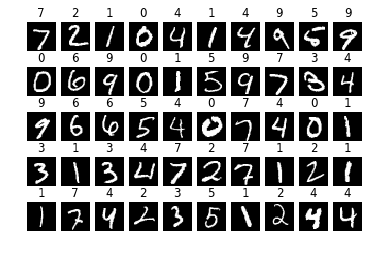

In [5]:
# Examine the dataset:
print(x_train.shape,y_train.shape,x_test.shape,y_test.shape)
print(np.min(x_train),np.max(x_train),np.min(y_train),np.max(y_train))
for i in range(50):
    subplot(5,10,i+1)
    imshow(x_test[i].reshape([28,28]),cmap='gray');
    title(str(y_test[i]));
    axis('off')

### 1.1 An autoencoder
ref: https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html#what-about-data

ref: https://morvanzhou.github.io/tutorials/machine-learning/tensorflow/5-11-autoencoder/

In [7]:
import torch.nn as nn

class autoencoder(nn.Module):
    def __init__(self):
        super(autoencoder, self).__init__()
        
        self.encoder = nn.Sequential(
            nn.Linear(28*28, 128),
            nn.ReLU(True),
            nn.Linear(128, 64),
            nn.ReLU(True),
            nn.Linear(64, 12),
            nn.ReLU(True),
            nn.Linear(12, 2) # 2-dimensional latent space
        )
        
        self.decoder = nn.Sequential(
            nn.Linear(2, 12),
            nn.ReLU(True),
            nn.Linear(12, 64),
            nn.ReLU(True),
            nn.Linear(64, 128),
            nn.ReLU(True),
            nn.Linear(128, 28*28),
            nn.Tanh()
        )

    def forward(self, x):
        encode = self.encoder(x)
        decode = self.decoder(encode)
        return encode, decode

### 1.2 Your visualization

disscuss with 申子欣

ref: http://tiao.io/listings/vae/variational_autoencoder.py.html

/raid/opt/hpc/anaconda/python3/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


Train on 60000 samples, validate on 10000 samples
Epoch 1/50
60000/60000 [==============================] - 6s 103us/step - loss: 190.4723 - val_loss: 172.7456
Epoch 2/50
60000/60000 [==============================] - 3s 57us/step - loss: 170.0829 - val_loss: 168.0064
Epoch 3/50
60000/60000 [==============================] - 4s 60us/step - loss: 166.8652 - val_loss: 165.7382
Epoch 4/50
60000/60000 [==============================] - 4s 60us/step - loss: 164.8016 - val_loss: 164.1158
Epoch 5/50
60000/60000 [==============================] - 4s 59us/step - loss: 163.2333 - val_loss: 162.7347
Epoch 6/50
60000/60000 [==============================] - 4s 65us/step - loss: 161.9915 - val_loss: 161.5196
Epoch 7/50
60000/60000 [==============================] - 4s 60us/step - loss: 160.8905 - val_loss: 160.6396
Epoch 8/50
60000/60000 [==============================] - 4s 62us/step - loss: 159.8690 - val_loss: 159.9456
Epoch 9/50
60000/60000 [==============================] - 4s 63us/step - loss

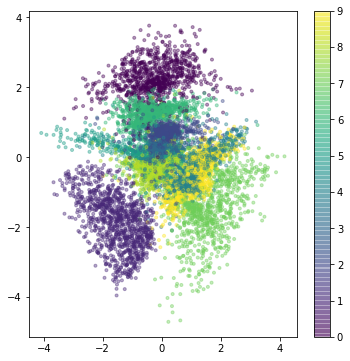

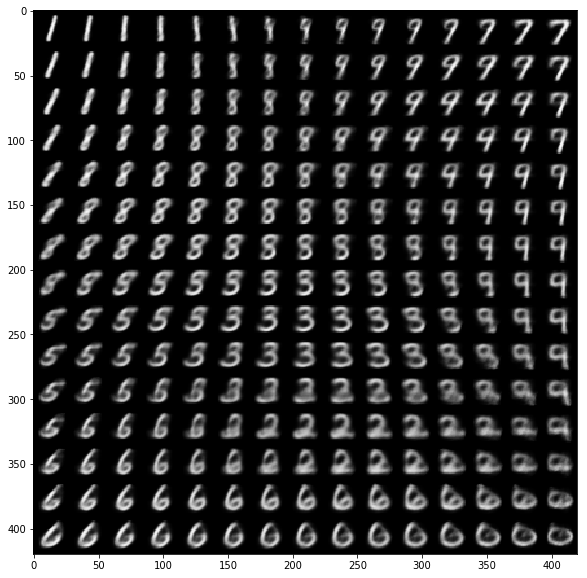

In [13]:
# Please run your analysis here
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

from keras import backend as K

from keras.layers import Input, Dense, Lambda, Layer, Add, Multiply
from keras.models import Model, Sequential
from keras.datasets import mnist


original_dim = 784
intermediate_dim = 256
latent_dim = 2
batch_size = 100
epochs = 50
epsilon_std = 1.0


def nll(y_true, y_pred):
    """ Negative log likelihood (Bernoulli). """

    # keras.losses.binary_crossentropy gives the mean
    # over the last axis. we require the sum
    return K.sum(K.binary_crossentropy(y_true, y_pred), axis=-1)


class KLDivergenceLayer(Layer):

    """ Identity transform layer that adds KL divergence
    to the final model loss.
    """

    def __init__(self, *args, **kwargs):
        self.is_placeholder = True
        super(KLDivergenceLayer, self).__init__(*args, **kwargs)

    def call(self, inputs):

        mu, log_var = inputs

        kl_batch = - .5 * K.sum(1 + log_var -
                                K.square(mu) -
                                K.exp(log_var), axis=-1)

        self.add_loss(K.mean(kl_batch), inputs=inputs)

        return inputs


decoder = Sequential([
    Dense(intermediate_dim, input_dim=latent_dim, activation='relu'),
    Dense(original_dim, activation='sigmoid')
])

x = Input(shape=(original_dim,))
h = Dense(intermediate_dim, activation='relu')(x)

z_mu = Dense(latent_dim)(h)
z_log_var = Dense(latent_dim)(h)

z_mu, z_log_var = KLDivergenceLayer()([z_mu, z_log_var])
z_sigma = Lambda(lambda t: K.exp(.5*t))(z_log_var)

eps = Input(tensor=K.random_normal(stddev=epsilon_std,
                                   shape=(K.shape(x)[0], latent_dim)))
z_eps = Multiply()([z_sigma, eps])
z = Add()([z_mu, z_eps])

x_pred = decoder(z)

vae = Model(inputs=[x, eps], outputs=x_pred)
vae.compile(optimizer='rmsprop', loss=nll)

# train the VAE on MNIST digits
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = x_train.reshape(-1, original_dim) / 255.
x_test = x_test.reshape(-1, original_dim) / 255.

vae.fit(x_train,
        x_train,
        shuffle=True,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=(x_test, x_test))

encoder = Model(x, z_mu)

# display a 2D plot of the digit classes in the latent space
z_test = encoder.predict(x_test, batch_size=batch_size)
plt.figure(figsize=(6, 6))
plt.scatter(z_test[:, 0], z_test[:, 1], c=y_test,
            alpha=.4, s=3**2, cmap='viridis')
plt.colorbar()
plt.show()

# display a 2D manifold of the digits
n = 15  # figure with 15x15 digits
digit_size = 28

# linearly spaced coordinates on the unit square were transformed
# through the inverse CDF (ppf) of the Gaussian to produce values
# of the latent variables z, since the prior of the latent space
# is Gaussian
u_grid = np.dstack(np.meshgrid(np.linspace(0.05, 0.95, n),
                               np.linspace(0.05, 0.95, n)))
z_grid = norm.ppf(u_grid)
x_decoded = decoder.predict(z_grid.reshape(n*n, 2))
x_decoded = x_decoded.reshape(n, n, digit_size, digit_size)

plt.figure(figsize=(10, 10))
plt.imshow(np.block(list(map(list, x_decoded))), cmap='gray')
plt.show()

## 2 Integer Factorization (3 points)

Here we explore the possibilty that a neural network may be able to judge whether an input integer is a prime number or not.

* Computational problem: tell if an input is a prime number 

* Network Input: an integer in binary code (e.g., 0→000000000000000 (15 bits); 1→000000000000001; 2→000000000000010)

* Network Output: 1 unit (1=yes; 0=no)

* Network Architecture: your choice

* Data set: You can enlarge your training and testing data sets, if necessary. Training accuracies and testing accuraces are both informative but of course we care more about the testing ones.

### 2.1 The data set

In [267]:
from math import sqrt; from itertools import count, islice

def isPrime(n):
    return n > 1 and all(n%i for i in islice(count(2), int(sqrt(n)-1)))

ifPrime=np.vectorize(isPrime)    

#create data
x=np.arange(32768) #2^15
y=ifPrime(x).astype(int) 

# Training-testing splits:

from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.20)

# Training data:
print(x_train.shape,x_train)
print(y_train.shape,y_train)

# Testing data:
print(x_test.shape,x_train)
print(y_test.shape,y_train)

# Conversion from an integer to it binary code:
format(x_train[0], '015b')


(26214,) [19626 11002  5735 ... 13800  4936 25687]
(26214,) [0 0 0 ... 0 0 0]
(6554,) [19626 11002  5735 ... 13800  4936 25687]
(6554,) [0 0 0 ... 0 0 0]


'100110010101010'

In [158]:
#change all data to 015b
#for i in range(len(x_train)):
#    x_train[i] = format(x_train[i], '015b')
#
#for i in range(len(x_test)):
#    x_test[i] = format(x_test[i], '015b')

### 2.2 Your model
ref: https://ieeexplore.ieee.org/document/1556309/references

In [268]:
import numpy as np
import torch as t

In [269]:
x_train = t.from_numpy(x_train)
x_test = t.from_numpy(x_test)
y_train = t.from_numpy(y_train)
y_test = t.from_numpy(y_test)

x_train = x_train.type(t.FloatTensor)
x_test = x_test.type(t.FloatTensor)
y_train = y_train.type(t.FloatTensor)
y_test = y_test.type(t.FloatTensor)

#x_train = x_train.view(len(x_train),1)
#x_test = x_test.view(len(x_test),1)
#y_train = y_train.view(len(y_train),1)
#y_test = y_test.view(len(y_test),1)


In [270]:
x_train = x_train.view(len(x_train),1)
x_test = x_test.view(len(x_test),1)
y_train = y_train.view(len(y_train),1)
y_test = y_test.view(len(y_test),1)

In [271]:
# Please train & evaluate your model here.

H=10000 # number of hidden units

model = t.nn.Sequential(
    t.nn.Linear(1, H, bias=True),
    t.nn.BatchNorm1d(H),
    t.nn.ReLU(),
    t.nn.Linear(H, 1, bias=True),
    t.nn.Sigmoid()
)

loss_fn = t.nn.L1Loss()
optimizer = t.optim.Adam(model.parameters())

for i in range(100):
    x_pred = model(x_train)
    #x_pred = x_pred.type(t.FloatTensor)
    if i!=0:
        y_train = y_train.view(y_train.shape[1],1)
    
    loss = loss_fn(x_pred.type(t.FloatTensor),y_train)
    model.zero_grad()
    loss.backward()
    optimizer.step()
    x_pred = model(x_train) 
    x_pred = t.max(x_pred,1)[1]
    
    x_pred = x_pred.type(t.FloatTensor)
    y_train = y_train.view(1,len(y_train))

    print('epoch ',i,':',(x_pred==y_train[0]).sum().item()/x_train.shape[0])


epoch  0 : 0.8942549782558938
epoch  1 : 0.8942549782558938
epoch  2 : 0.8942549782558938
epoch  3 : 0.8942549782558938
epoch  4 : 0.8942549782558938
epoch  5 : 0.8942549782558938


KeyboardInterrupt: 

### Disscussion

為了處理datatype的問題而寫了一堆很醜的code，用了非常簡單的neural network，每一次epoch跑出來正確率都沒有進步。(所以中途就把在跑的code關掉了。)

就本質上去討論，質數應該是沒有規律的，那麼neural network要能夠判斷是否是質數就不太可能，除非仍是用過去的算法。若是那樣，把這個問題放讚neural network的框架下會有什麼不同於過去的好處呢？又或者換另外一種方式思考，如果能訓練出一個"有效率"的neural network去判斷此數是否為質數，那應該會在密碼學界造成大轟動，像是RSA加密的方法就會開始不安全，大概會有大批新聞出現吧！

所以從比較直接還有間接的資訊來做推論，若不擺脫傳統算法的精神，在把質數範圍拉大時，應該還是無法train出一個有效率的neural network去判斷輸入的數字是不是質數。



ref:  https://stackoverflow.com/questions/4114167/checking-if-a-number-is-a-prime-number-in-python/27946768